# Step By Step 04 - 因子预处理
--------------

在因子进入产生信号之前，我们一般都需要进行因子预处理（主要包括：标准化、去极值等）

In [11]:
%matplotlib inline
import os
from matplotlib import pyplot as plt
from alphamind.api import *
from alphamind.data.standardize import standardize
from alphamind.data.winsorize import winsorize_normal
from alphamind.data.neutralize import neutralize
from alphamind.data.engines.sqlengine.mysql import risk_styles

engine = SqlEngine(os.environ['DB_URI'])
engine

In [2]:
# 首先我们准备原始数据

universe = Universe("HS300")
codes = engine.fetch_codes("2020-07-30", universe)  # 获取沪深300成分股

raw_factor = engine.fetch_factor("2020-07-30", factors=["EMV6D"], codes=codes).dropna()
raw_factor.head()

,EMV6D,code,chgPct,secShortName
0,-0.001850,2010000001,-1.0466,浦发银行
1,-0.008067,2010000005,-2.0237,白云机场
2,-0.400354,2010000010,-1.7115,上海机场
3,0.000000,2010000011,-0.8475,包钢股份
4,-0.000154,2010000012,0.0000,华能国际


## 一、标准化

<AxesSubplot:>

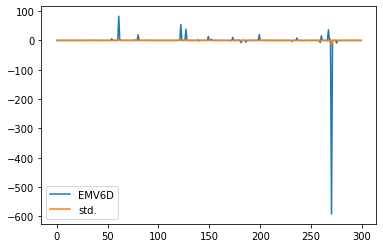

In [3]:
raw_factor["std."] = standardize(raw_factor[["EMV6D"]].values)

figure = plt.figure()
ax = figure.gca()

raw_factor[["EMV6D"]].plot(ax=ax)
raw_factor[["std."]].plot(ax=ax)

## 二、去极值

<AxesSubplot:>

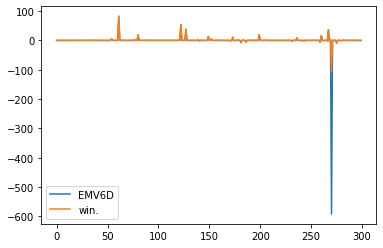

In [4]:
raw_factor["win."] = winsorize_normal(raw_factor[["EMV6D"]].values)

figure = plt.figure()
ax = figure.gca()

raw_factor[["EMV6D"]].plot(ax=ax)
raw_factor[["win."]].plot(ax=ax)

## 三、中性化

这一步是最具有量化特色的处理。对于因子模型而言，我们一般都要对原始因子，基于**风险因子**进行中性化处理，只保留残差部分。

In [27]:
risk_model = engine.fetch_risk_model("2020-07-30", codes=codes)[1]
risk_model = risk_model.loc[risk_model.code.isin(raw_factor.code), risk_styles]

<AxesSubplot:>

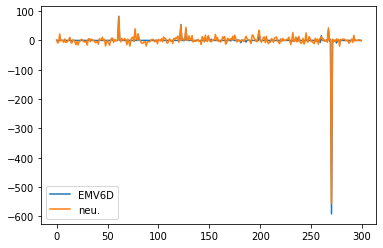

In [35]:
raw_factor["neu."] = neutralize(risk_model.values, raw_factor[["EMV6D"]].values)

figure = plt.figure()
ax = figure.gca()

raw_factor[["EMV6D"]].plot(ax=ax)
raw_factor[["neu."]].plot(ax=ax)

## 四、pipeline

**alpha-mind** 已经提供了一个统一的processing函数，用户可以同时将多步预处理整合在一条pipeline里面。

In [36]:
from alphamind.data.processing import factor_processing

In [37]:
raw_factor["complex."] = factor_processing(raw_factor[["EMV6D"]].values,
                                           pre_process=[standardize, winsorize_normal],
                                           risk_factors=risk_model.values)

<AxesSubplot:>

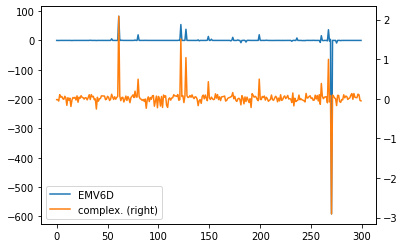

In [39]:
figure = plt.figure()
ax = figure.gca()

raw_factor[["EMV6D"]].plot(ax=ax)
raw_factor[["complex."]].plot(ax=ax, secondary_y=True)